Chemin utilisé pour contours : E:\Mes PDF\M1 LMD\Semestre2\Traitement d'images\TP_Traitement_Images_M1AI\TP2_Filtres\Data_TP1_extracted\Data_TP1\TP2\tp24.png


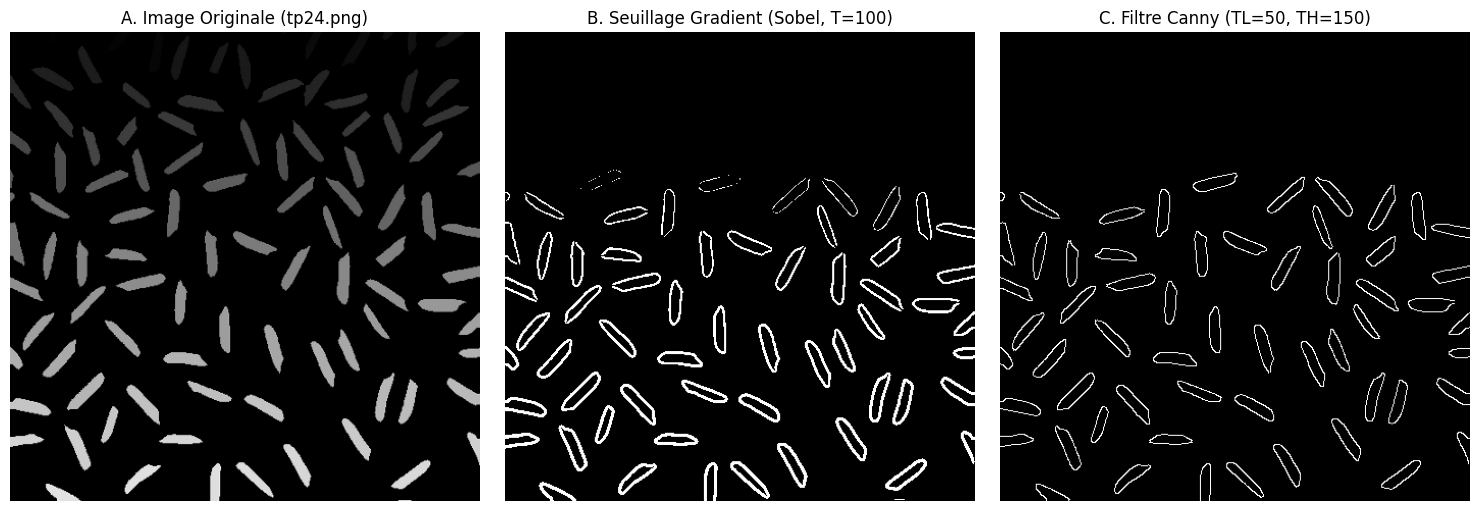

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile

notebook_dir = Path().resolve()

def resolve_image_path(rel_path):
    rel = Path(rel_path)
    # si le chemin existe déjà (absolu ou relatif)
    if rel.exists():
        return str(rel)
    # si le chemin commence par un zip (ex: Data_TP1.zip/...)
    parts = rel.parts
    if parts and parts[0].lower().endswith('.zip'):
        zip_name = parts[0]
        # chercher le zip dans le dossier du notebook, parent et dossiers frères
        search_dirs = [notebook_dir, notebook_dir.parent] + [p for p in notebook_dir.parent.iterdir() if p.is_dir()]
        zip_candidate = None
        for d in search_dirs:
            z = d / zip_name
            if z.exists() and zipfile.is_zipfile(z):
                zip_candidate = z
                break
        if zip_candidate:
            extract_dir = notebook_dir / (zip_candidate.stem + '_extracted')
            if not extract_dir.exists():
                extract_dir.mkdir(parents=True, exist_ok=True)
                with zipfile.ZipFile(zip_candidate, 'r') as zf:
                    zf.extractall(extract_dir)
            inner = Path(*parts[1:])
            candidate = extract_dir / inner
            if candidate.exists():
                return str(candidate)
    # rechercher par nom dans dossiers plausibles (notebook, parent, frères)
    filename = rel.name
    search_dirs = [notebook_dir, notebook_dir.parent] + [p for p in notebook_dir.parent.iterdir() if p.is_dir()]
    for d in search_dirs:
        candidates = [
            d / filename,
            d / "TP2" / filename,
            d / "TP1" / "TP2" / filename,
            d / "Data_TP1" / "TP2" / filename,
        ]
        for c in candidates:
            if c.exists():
                return str(c)
    # fallback : retourner le chemin original
    return str(rel_path)

# --- PARAMETRES ---
IMAGE_PATH_CONTOURS = "Data_TP1.zip/Data_TP1/TP2/tp24.png"
SOBEL_THRESHOLD = 100
CANNY_MIN_VAL = 50
CANNY_MAX_VAL = 150

# résoudre le chemin avant lecture
real_contour_path = resolve_image_path(IMAGE_PATH_CONTOURS)
print("Chemin utilisé pour contours :", real_contour_path)

# --- CHARGEMENT ET PRÉ-TRAITEMENT ---
image_originale = cv2.imread(real_contour_path, 0)
if image_originale is None:
    raise FileNotFoundError(
        f"Erreur: Impossible de charger l'image.\n"
        f"Chemin demandé : {IMAGE_PATH_CONTOURS}\n"
        f"Chemin utilisé  : {real_contour_path}\n"
        "Vérifiez que Data_TP1.zip ou les images TP2 sont dans le dossier du notebook (ou dans un dossier frère)."
    )
# Appliquer un léger flou Gaussien pour le débruitage initial
image_lissée = cv2.GaussianBlur(image_originale, (5, 5), 0)

# --- 1. Seuillage sur la Norme du Gradient (Sobel) ---

# Calculer les gradients en X et Y
sobelx = cv2.Sobel(image_lissée, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image_lissée, cv2.CV_64F, 0, 1, ksize=3)

# Calculer la norme du gradient (magnitude)
magnitude = np.sqrt(sobelx**2 + sobely**2)
# Normaliser l'image de magnitude pour l'affichage (0-255)
magnitude_norm = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Appliquer un seuil binaire sur la magnitude
_, contours_sobel = cv2.threshold(magnitude_norm, SOBEL_THRESHOLD, 255, cv2.THRESH_BINARY)


# --- 2. Filtre de Canny ---

# Appliquer l'algorithme de Canny
contours_canny = cv2.Canny(image_lissée, CANNY_MIN_VAL, CANNY_MAX_VAL)

# --- VISUALISATION DES RESULTATS (Pour la figure TP2_Contours_Compare.png) ---
titres = [
    f"A. Image Originale ({IMAGE_PATH_CONTOURS.split('/')[-1]})", 
    f"B. Seuillage Gradient (Sobel, T={SOBEL_THRESHOLD})", 
    f"C. Filtre Canny (TL={CANNY_MIN_VAL}, TH={CANNY_MAX_VAL})"
]
images = [image_originale, contours_sobel, contours_canny]

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titres[i])
    plt.axis('off')

plt.tight_layout()
plt.show()